In [202]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix

from pprint import pprint

# classifiers
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from scipy.stats import randint, uniform

sns.set(font_scale = 1.25)
# reproducibility
seed = 142

In [181]:
#check requirements

print(sys.version)
print('numpy: {}'.format(np.version.version))
print('sklearn: {}'.format(sklearn.__version__))
print('xgboost: {}'.format(xgboost.__version__))

3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
numpy: 1.18.1
sklearn: 0.20.1
xgboost: 1.1.1


### Data Exploration

We will be working on **German Credit** data set. This dataset has two classes to describe the worthiness of a personal loan: "Good" or "Bad". There are 61 predictors related to their attributes.

Many of these predictors are discrete and have been expanded into several 0/1 indicator variables (a.k.a. they have been one-hot-encoded).

This dataset has been kindly provided by Professor Dr. Hans Hofmann of the University of Hamburg, and can also be found on the UCI Machine Learning Repository.

In [186]:
df = pd.read_csv("C:\\Users\\Chaitanya\\Desktop\\Machine Learning\\Springboard\\tree-based-algorithm\\GermanCredit.csv")
df.head()

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,Age,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,Class,...,OtherInstallmentPlans.Bank,OtherInstallmentPlans.Stores,OtherInstallmentPlans.None,Housing.Rent,Housing.Own,Housing.ForFree,Job.UnemployedUnskilled,Job.UnskilledResident,Job.SkilledEmployee,Job.Management.SelfEmp.HighlyQualified
0,6,1169,4,4,67,2,1,0,1,Good,...,0,0,1,0,1,0,0,0,1,0
1,48,5951,2,2,22,1,1,1,1,Bad,...,0,0,1,0,1,0,0,0,1,0
2,12,2096,2,3,49,1,2,1,1,Good,...,0,0,1,0,1,0,0,1,0,0
3,42,7882,2,4,45,1,2,1,1,Good,...,0,0,1,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,Bad,...,0,0,1,0,0,1,0,0,1,0


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 62 columns):
Duration                                  1000 non-null int64
Amount                                    1000 non-null int64
InstallmentRatePercentage                 1000 non-null int64
ResidenceDuration                         1000 non-null int64
Age                                       1000 non-null int64
NumberExistingCredits                     1000 non-null int64
NumberPeopleMaintenance                   1000 non-null int64
Telephone                                 1000 non-null int64
ForeignWorker                             1000 non-null int64
Class                                     1000 non-null object
CheckingAccountStatus.lt.0                1000 non-null int64
CheckingAccountStatus.0.to.200            1000 non-null int64
CheckingAccountStatus.gt.200              1000 non-null int64
CheckingAccountStatus.none                1000 non-null int64
CreditHistory.NoCredit.Al

In [196]:
df.describe()

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,Age,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,CheckingAccountStatus.lt.0,...,OtherInstallmentPlans.Bank,OtherInstallmentPlans.Stores,OtherInstallmentPlans.None,Housing.Rent,Housing.Own,Housing.ForFree,Job.UnemployedUnskilled,Job.UnskilledResident,Job.SkilledEmployee,Job.Management.SelfEmp.HighlyQualified
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.596000,0.963000,0.274000,...,0.13900,0.047000,0.814000,0.179000,0.713000,0.108000,0.022000,0.2000,0.630000,0.148000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.490943,0.188856,0.446232,...,0.34612,0.211745,0.389301,0.383544,0.452588,0.310536,0.146757,0.4002,0.483046,0.355278
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0000,1.000000,0.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0000,1.000000,0.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000


We have a mix of categorical and continuous variables.

The target variable `Class` is a categorical. Let's explore it.

In [197]:
df['Class'].value_counts()

Good    700
Bad     300
Name: Class, dtype: int64

The data set is not balanced, so we need to take care of that. 

Lets convert the strings into numerical values for the target. `{"Good" : 1, "Bad" : 0}`

In [198]:
transform = {"Class": {"Good" : 1, "Bad" : 0}}

df.replace(transform, inplace=True)
df['Class'].value_counts()

1    700
0    300
Name: Class, dtype: int64

In [199]:
for column in df:
    if df[column].max() > 1:
        print('{}: {}'.format(column, df[column].max()))

Duration: 72
Amount: 18424
InstallmentRatePercentage: 4
ResidenceDuration: 4
Age: 75
NumberExistingCredits: 4
NumberPeopleMaintenance: 2


`Duration`, `Amount` & `Age` are the only columns with numerical values.

Let's take a look a the distributions of the continuous variables to check for outliers etc.

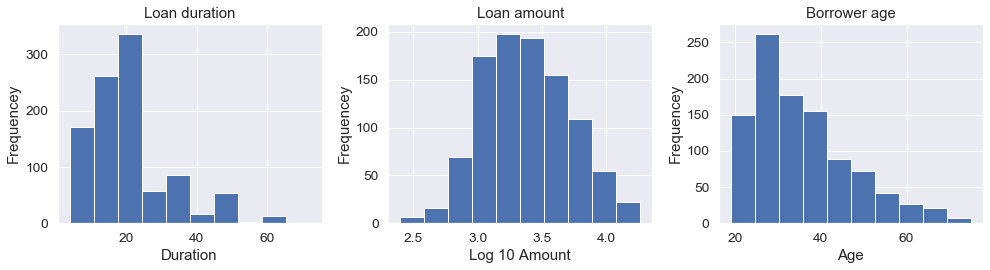

In [201]:
plt.subplots(1,3, figsize=(14,4))

plt.subplot(1,3, 1)
plt.hist(df.Duration)
plt.title("Loan duration")
plt.xlabel("Duration")
plt.ylabel("Frequencey")

plt.subplot(1,3, 2)
plt.hist(np.log10(df.Amount))
plt.title("Loan amount")
plt.xlabel("Log 10 Amount")
plt.ylabel("Frequencey")

plt.subplot(1,3, 3)
plt.hist(df.Age)
plt.title("Borrower age")
plt.xlabel("Age")
plt.ylabel("Frequencey")

plt.tight_layout()
plt.show()

In [91]:
X = df.drop(['Class'], axis = 1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(750, 61) (250, 61) (750,) (250,)


### Single Decision Tree
The following code will create a single decision tree, fit it using training data and evaluate the results using test sample.

In [10]:
decision_tree = DecisionTreeClassifier(random_state=seed)

# train classifier
decision_tree.fit(X_train, y_train)

# predict output
decision_tree_y_pred  = decision_tree.predict(X_test)
decision_tree_y_pred_prob  = decision_tree.predict_proba(X_test)

# evaluation
decision_tree_accuracy = accuracy_score(y_test, decision_tree_y_pred)
decision_tree_logloss = log_loss(y_test, decision_tree_y_pred_prob)

print("== Decision Tree ==")
print("Accuracy: {0:.2f}".format(decision_tree_accuracy))
print("Log loss: {0:.2f}".format(decision_tree_logloss))
print("Number of nodes created: {}".format(decision_tree.tree_.node_count))

== Decision Tree ==
Accuracy: 0.66
Log loss: 11.74
Number of nodes created: 293


We can see two things:

1. the log loss score is not very promising (due to the fact that leaves in decision tree outputs either `0` or `1` as probability which is heaviliy penalized in case of errors, but the accuracy score is quite decent,
2. the tree is complicated (large number of nodes)

### AdaBoost
In the example below we are creating a AdaBoost classifier running on 1000 iterations (1000 trees created). Also we are growing decision node up to first split (they are called *decision stumps*). We are also going to use `SAMME` algorithm which is inteneded to work with discrete data (output from `base_estimator` is `0` or `1`). Please refer to the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) and [here](http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_hastie_10_2.html) for more details.

In [13]:
adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    algorithm='SAMME',
    n_estimators=1000,
    random_state=seed)

# train classifier
adaboost.fit(X_train, y_train)

# calculate predictions
adaboost_y_pred = adaboost.predict(X_test)
adaboost_y_pred_prob = adaboost.predict_proba(X_test)

# evaluate
adaboost_accuracy = accuracy_score(y_test, adaboost_y_pred)
adaboost_logloss = log_loss(y_test, adaboost_y_pred_prob)

print("== AdaBoost ==")
print("Accuracy: {0:.2f}".format(adaboost_accuracy))
print("Log loss: {0:.2f}".format(adaboost_logloss))

== AdaBoost ==
Accuracy: 0.72
Log loss: 0.68


What's it's error and contribution into final ensemble

In [14]:
print("Error: {0:.2f}".format(adaboost.estimator_errors_[0]))
print("Tree importance: {0:.2f}".format(adaboost.estimator_weights_[0]))

Error: 0.31
Tree importance: 0.82


### Gradient Boosted Trees
Let's construct a gradient boosted tree consiting of 1000 trees where each successive one will be created with gradient optimization. Again we are going to leave most parameters with their default values, specifiy only maximum depth of the tree to 1 (again decision stumps), and setting warm start for more intelligent computations. Please refer to the [docs](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) if something is not clear.

In [15]:
gbc = GradientBoostingClassifier(
    max_depth=1,
    n_estimators=1000,
    warm_start=True,
    random_state=seed)
gbc.fit(X_train, y_train)

# make predictions
gbc_y_pred = gbc.predict(X_test)
gbc_y_pred_prob = gbc.predict_proba(X_test)

# calculate log loss
gbc_accuracy = accuracy_score(y_test, gbc_y_pred)
gbc_logloss = log_loss(y_test, gbc_y_pred_prob)

print("== Gradient Boosting ==")
print("Accuracy: {0:.2f}".format(gbc_accuracy))
print("Log loss: {0:.2f}".format(gbc_logloss))

== Gradient Boosting ==
Accuracy: 0.73
Log loss: 0.54


The obtained results are obviously the best of all presented algorithm. We have obtained most accurate algorithm giving more sensible predictions about class probabilities.

The difference is that GBC uses `DecisionTreeRegressor` classifier as the estimator with *mean-square error* as criterion. This results of slightly different output of the tree - now the leaf contains a predicted value (while the first splitting point remains the same).

### XGBoost


#### Specify training parameters
Let's make the following assuptions and adjust algorithm parameters to it:
- we are dealing with binary classification problem (`'objective':'binary:logistic'`),
- we want shallow single trees with no more than 2 levels (`'max_depth':2`),
- we want algorithm to learn fast and aggressively (`'eta':1`),
- we want to iterate only 5 rounds

In [21]:
xgb_mod = XGBClassifier() 

params = {
    'objective':'binary:logistic',
    'max_depth':2,
    'eta':1
}

num_rounds = 5

tree = xgb_mod.fit(X_train, y_train)

In [20]:
gbc_y_pred = xgb_mod.predict(X_test)
gbc_y_pred_prob = xgb_mod.predict_proba(X_test)

# calculate log loss
gbc_accuracy = accuracy_score(y_test, gbc_y_pred)
gbc_logloss = log_loss(y_test, gbc_y_pred_prob)

print("== Gradient Boosting ==")
print("Accuracy: {0:.2f}".format(gbc_accuracy))
print("Log loss: {0:.2f}".format(gbc_logloss))

== Gradient Boosting ==
Accuracy: 0.72
Log loss: 0.77


### Using standard XGBoost interface

In [29]:
df.head()

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,Age,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,Class,...,OtherInstallmentPlans.Bank,OtherInstallmentPlans.Stores,OtherInstallmentPlans.None,Housing.Rent,Housing.Own,Housing.ForFree,Job.UnemployedUnskilled,Job.UnskilledResident,Job.SkilledEmployee,Job.Management.SelfEmp.HighlyQualified
0,6,1169,4,4,67,2,1,0,1,1,...,0,0,1,0,1,0,0,0,1,0
1,48,5951,2,2,22,1,1,1,1,0,...,0,0,1,0,1,0,0,0,1,0
2,12,2096,2,3,49,1,2,1,1,1,...,0,0,1,0,1,0,0,1,0,0
3,42,7882,2,4,45,1,2,1,1,1,...,0,0,1,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,0,...,0,0,1,0,0,1,0,0,1,0


In [30]:
train, test = train_test_split(df, random_state = 5)
print(train.shape, test.shape)

(750, 62) (250, 62)


In [111]:
predictors = X.columns

xgtrain = xgb.DMatrix(train[predictors].values, label = train['Class'].values)
xgtest = xgb.DMatrix(test[predictors].values, label = test['Class'].values)

In [112]:
print("Train dataset contains {0} rows and {1} columns".format(xgtrain.num_row(), xgtrain.num_col()))
print("Test dataset contains {0} rows and {1} columns".format(xgtest.num_row(), xgtest.num_col()))

Train dataset contains 750 rows and 61 columns
Test dataset contains 250 rows and 61 columns


In [113]:
print("Train possible labels: ")
print(np.unique(xgtrain.get_label()))

print("\nTest possible labels: ")
print(np.unique(xgtest.get_label()))

Train possible labels: 
[0. 1.]

Test possible labels: 
[0. 1.]


In [114]:
# specify training parameters
params = {
    'objective':'binary:logistic',
    'max_depth':2,
    'eta':0.5
}

num_rounds = 5

# watchlist to observe it's performance on the test set.

watchlist  = [(xgtest,'test'), (xgtrain,'train')] # native interface only
bst = xgb.train(params, xgtrain, num_rounds, watchlist)

[0]	test-error:0.31200	train-error:0.27733
[1]	test-error:0.27600	train-error:0.25200
[2]	test-error:0.28000	train-error:0.25200
[3]	test-error:0.28800	train-error:0.23467
[4]	test-error:0.26400	train-error:0.23600


In [36]:
#representation of a tree

trees_dump = bst.get_dump(with_stats=True)

for tree in trees_dump:
    print(tree)

0:[f12<0.5] yes=1,no=2,missing=1,gain=68.7618484,cover=187.5
	1:[f0<20.5] yes=3,no=4,missing=3,gain=23.1589737,cover=114
		3:leaf=0.346774191,cover=61
		4:leaf=-0.101851851,cover=53
	2:[f53<0.5] yes=5,no=6,missing=5,gain=9.16821289,cover=73.5
		5:leaf=0.306122452,cover=11.25
		6:leaf=0.833992124,cover=62.25

0:[f9<0.5] yes=1,no=2,missing=1,gain=31.7666397,cover=175.622665
	1:[f1<9340.5] yes=3,no=4,missing=3,gain=18.2314911,cover=124.483093
		3:leaf=0.40164423,cover=117.124512
		4:leaf=-0.372783393,cover=7.35857773
	2:[f17<0.5] yes=5,no=6,missing=5,gain=15.2338734,cover=51.1395683
		5:leaf=-0.272492766,cover=37.9097328
		6:leaf=0.333073109,cover=13.2298336

0:[f12<0.5] yes=1,no=2,missing=1,gain=17.3685493,cover=161.282486
	1:[f0<11.5] yes=3,no=4,missing=3,gain=13.0814409,cover=107.206818
		3:leaf=0.415695965,cover=15.7819433
		4:leaf=-0.064162612,cover=91.4248734
	2:[f53<0.5] yes=5,no=6,missing=5,gain=5.21288681,cover=54.0756721
		5:leaf=0.0271313004,cover=10.06528
		6:leaf=0.42798391,c

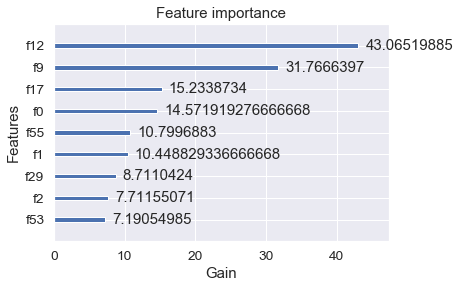

In [43]:
xgb.plot_importance(bst, importance_type='gain', xlabel='Gain')
plt.show()

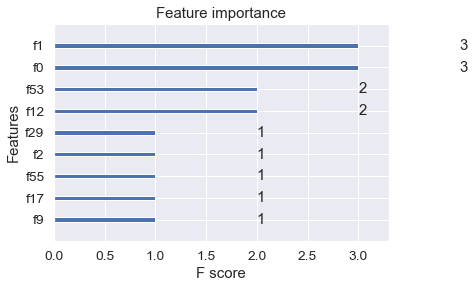

In [44]:
xgb.plot_importance(bst)
plt.show()

In [45]:
importances = bst.get_fscore()
importances

{'f12': 2,
 'f0': 3,
 'f53': 2,
 'f9': 1,
 'f1': 3,
 'f17': 1,
 'f55': 1,
 'f2': 1,
 'f29': 1}

### Cross Validation

In [47]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv.get_n_splits(X, y)

10

In [50]:
#Let's check how the number of trees influence the predictions accuracy.

default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
)

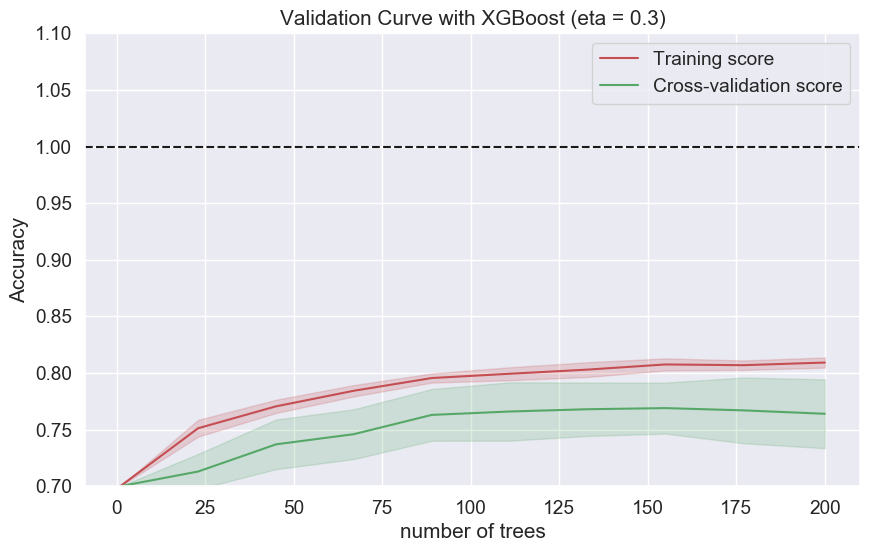

Best cross-validation result (0.77) obtained for 155 trees


In [51]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

Looking at the plot we can draw the following conclusions:

- training score keeps growing while adding new trees, but from a certain point CV score is fixed
- variance is lowest, and bias is high for less than 75 trees,
- from about 50 (approx.) trees, the variance is getting higher 
- the CV score bias is holding steady (there is no point for adding extra trees / complexity) after 85 trees (approx.)
- we can see that the model is quite stable keeping variance fixed when increasing it's complexity

We can assume that the trade-off for our model will be met at `n_estimators = 100`. The variance is still to big.

### What we can do?

#### Dealing with high variance
If model is too complex try:
- using less features (ie. feature selection),
- using more training samples (ie. artificially generated),
- increasing regularization (add penalties for extra complexity)

In XGBoost you can try to:
- reduce depth of each tree (`max_depth`),
- increase `min_child_weight` parameter,
- increase `gamma` parameter,
- add more randomness using `subsample`, `colsample_bytree` parameters,
- increase `lambda` and `alpha` regularization parameters

#### Dealing with high bias
If model is too simple:
- add more features (ie. better feature engineering),
- more sophisticated model
- decrease regularization

In XGBoost you can do it by:
- increase depth of each tree (`max_depth`),
- decrease `min_child_weight` parameter,
- decrease `gamma` parameter,
- decrease `lambda` and `alpha` regularization parameters

Let's try to tweak a parameters a little bit. We are going to add some randomness - each tree we will use 70% randomly chosen samples and 60% randomly chosen features. This should help to reduce a variance. To decrease the bias (bigger accuracy) try adding an extra level to each tree.

In [54]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 2, # changed
    'learning_rate': 0.3,
    'colsample_bytree': 0.6, # added
    'subsample': 0.7 # added
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

start = time()

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
)

print('Time required: {0:.2f}'.format( (time()-start)/60))

Time required: 0.26


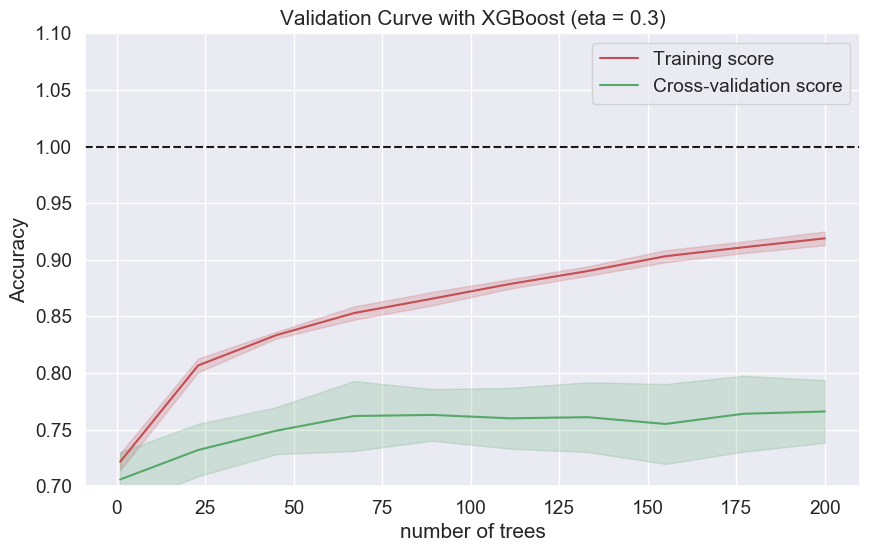

Best cross-validation result (0.77) obtained for 200 trees


In [55]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

In [57]:
import platform
platform.architecture()

('64bit', 'WindowsPE')

In [58]:
import struct
print(struct.calcsize("P") * 8)

64


#### Grid Search

In [92]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

params_grid = {
    'max_depth': [1, 2, 3],
    'n_estimators': [5, 10, 25, 50, 100],
    'learning_rate': np.linspace(1e-16, 1, 3)
}

params_fixed = {
    'objective': 'binary:logistic',
}

In [93]:
bst_grid = GridSearchCV(
    estimator=XGBClassifier(**params_fixed, seed=seed),
    param_grid=params_grid,
    cv=cv,
    scoring='accuracy'
)

In [94]:
bst_grid.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=142, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w...t=None, seed=142, subsample=None,
       tree_method=None, validate_parameters=None, verbosity=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 2, 3], 'n_estimators': [5, 10, 25, 50, 100], 'learning_rate': array([1.e-16, 5.e-01, 1.e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [95]:
print("Best accuracy obtained: {0}".format(bst_grid.best_score_))
print("Parameters:")
for key, value in bst_grid.best_params_.items():
    print("\t{}: {}".format(key, value))

Best accuracy obtained: 0.768
Parameters:
	learning_rate: 0.5
	max_depth: 2
	n_estimators: 50


#### Ramdomized Grid Search
When the number of parameters and their values is getting big traditional grid-search approach quickly becomes ineffective. A possible solution might be to randomly pick certain parameters from their distribution. While it's not an exhaustive solution, it's worth giving a shot.

In [96]:
params_dist_grid = {
    'max_depth': [1, 2, 3, 4],
    'gamma': [0, 0.5, 1],
    'n_estimators': randint(1, 1000), # uniform discrete random distribution
    'learning_rate': uniform(), # gaussian distribution
    'subsample': uniform(), # gaussian distribution
    'colsample_bytree': uniform() # gaussian distribution
}

In [97]:
rs_grid = RandomizedSearchCV(
    estimator=XGBClassifier(**params_fixed, seed=seed),
    param_distributions=params_dist_grid,
    n_iter=10,
    cv=cv,
    scoring='accuracy',
    random_state=seed
)

In [98]:
start = time()

rs_grid.fit(X, y)

print('Time required: {0:.2f} min'.format( (time()-start)/60))

Time required: 0.70 min


In [99]:
rs_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7062424583521489, gamma=0.5,
       gpu_id=-1, importance_type='gain', interaction_constraints='',
       learning_rate=0.0368712682669422, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=805, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=142, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=142,
       subsample=0.3077217748386869, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [100]:
rs_grid.best_params_

{'colsample_bytree': 0.7062424583521489,
 'gamma': 0.5,
 'learning_rate': 0.0368712682669422,
 'max_depth': 1,
 'n_estimators': 805,
 'subsample': 0.3077217748386869}

In [101]:
rs_grid.best_score_

0.763

In [102]:
xgb_mod = XGBClassifier(colsample_bytree = 0.066,
                         gamma = 0,
                         learning_rate = 0.33,
                         max_depth = 1,
                         n_estimators = 467,
                         subsample = 0.52) 

start = time()
xgb_mod.fit(X_train, y_train)

y_predict_train = xgb_mod.predict(X_train)
y_predict_test = xgb_mod.predict(X_test)

print(classification_report(y_predict_train, y_train))
print(classification_report(y_predict_test, y_test))
print(confusion_matrix(y_predict_test, y_test))
print((time()-start)/60)

              precision    recall  f1-score   support

           0       0.60      0.74      0.67       180
           1       0.91      0.85      0.88       570

   micro avg       0.82      0.82      0.82       750
   macro avg       0.76      0.80      0.77       750
weighted avg       0.84      0.82      0.83       750

              precision    recall  f1-score   support

           0       0.50      0.68      0.58        57
           1       0.90      0.80      0.84       193

   micro avg       0.77      0.77      0.77       250
   macro avg       0.70      0.74      0.71       250
weighted avg       0.81      0.77      0.78       250

[[ 39  18]
 [ 39 154]]
0.0049499591191609705


### Handling imbalanced dataset 

In [119]:
print('There are {} positive instances.'.format(y.sum()))
print('There are {} negative instances.'.format(len(df) - y.sum()))

There are 700 positive instances.
There are 300 negative instances.


In [120]:
print('There are {} positive instances.'.format(y_train.sum()))
print('There are {} negative instances.'.format(len(y_train) - y_train.sum()))

There are 528 positive instances.
There are 222 negative instances.


In [121]:
print('There are {} positive instances.'.format(y_test.sum()))
print('There are {} negative instances.'.format(len(y_test) - y_test.sum()))

There are 172 positive instances.
There are 78 negative instances.


In [130]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

In [123]:
print("Train dataset contains {0} rows and {1} columns".format(dtrain.num_row(), dtrain.num_col()))
print("Test dataset contains {0} rows and {1} columns".format(dtest.num_row(), dtest.num_col()))

Train dataset contains 750 rows and 61 columns
Test dataset contains 250 rows and 61 columns


In [124]:
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'eta':1
}

num_rounds = 15

xgboost_1 = xgb.train(params, dtrain, num_rounds)
y_test_preds = (xgboost_1.predict(dtest) > 0.5).astype('int')

In [140]:
print(confusion_matrix(y_test_preds, y_test))

[[ 31  17]
 [ 47 155]]


In [141]:
print(classification_report(y_test_preds, y_test))

              precision    recall  f1-score   support

           0       0.40      0.65      0.49        48
           1       0.90      0.77      0.83       202

   micro avg       0.74      0.74      0.74       250
   macro avg       0.65      0.71      0.66       250
weighted avg       0.80      0.74      0.76       250



In [144]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.74
Precision: 0.77
Recall: 0.90


Intuitively we know that the focus should be on finding bad loans i.e. zero. First results are very promising (90% recall - wow), but deeper analysis show that the results are biased towards majority class (one - good loans) - we are very poor at predicting the actual label of negative instances (**0.4 precision for zero**). 

#### Custom weights
Try to explicitly tell the algorithm what important using relative instance weights. Let's specify that positive instances have 5x more weight and add this information while creating `DMatrix`.

In [164]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 5
weights[y_train == 1] = 1

dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights) # weights added
dtest = xgb.DMatrix(X_test)

In [165]:
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

In [166]:
print(confusion_matrix(y_test_preds, y_test))
print(classification_report(y_test_preds, y_test))

[[69 86]
 [ 9 86]]
              precision    recall  f1-score   support

           0       0.88      0.45      0.59       155
           1       0.50      0.91      0.64        95

   micro avg       0.62      0.62      0.62       250
   macro avg       0.69      0.68      0.62       250
weighted avg       0.74      0.62      0.61       250



In [167]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.62
Precision: 0.91
Recall: 0.50


There are 78 bad loans and we are able to predict 69 one of them **(88%)**.

#### Using `scale_pos_weight` parameter
You can automate the process of assigning weights manually by calculating the proportion between negative and positive instances and setting it to `scale_pos_weight` parameter.

In [168]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [169]:
train_labels = dtrain.get_label()

ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio

In [172]:
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

In [173]:
print(confusion_matrix(y_test_preds, y_test))
print(classification_report(y_test_preds, y_test))

[[ 54  57]
 [ 24 115]]
              precision    recall  f1-score   support

           0       0.69      0.49      0.57       111
           1       0.67      0.83      0.74       139

   micro avg       0.68      0.68      0.68       250
   macro avg       0.68      0.66      0.66       250
weighted avg       0.68      0.68      0.66       250



In [174]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.68
Precision: 0.83
Recall: 0.67
